# Import Libraries

In [9]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime as dt
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Layer
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
import optuna
from optuna.integration import TFKerasPruningCallback, XGBoostPruningCallback
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier

print("✅ Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")


✅ Libraries imported successfully
TensorFlow version: 2.20.0


# Load MIMIC Perform AF Dataset

**Dataset info:**
- AF: 16 pasien (mimic_perform_af_001 - mimic_perform_af_016)
- Non-AF: 16 pasien (mimic_perform_non_af_001 - mimic_perform_non_af_016)
- Sampling Rate: 125Hz
- Duration: ~20 menit per pasien (150,000 samples)
- Columns: Time, PPG, ECG, resp

In [10]:
# Path configuration
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

af_folder = os.path.join(project_root, 'Data', 'af')
nonaf_folder = os.path.join(project_root, 'Data', 'non-af')

# List files - Balance: AF only up to patient 16
af_files_all = sorted(glob.glob(os.path.join(af_folder, '*_data.csv')))
af_files = af_files_all[:16]
nonaf_files = sorted(glob.glob(os.path.join(nonaf_folder, '*_data.csv')))

print("="*60)
print("DATASET: MIMIC Perform AF (Balanced)")
print("="*60)
print(f"\n📁 AF Folder: {af_folder}")
print(f"   Patients: {len(af_files)}")
print(f"\n📁 Non-AF Folder: {nonaf_folder}")
print(f"   Patients: {len(nonaf_files)}")
print(f"\n📊 Total Patients: {len(af_files) + len(nonaf_files)}")

DATASET: MIMIC Perform AF (Balanced)

📁 AF Folder: c:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\Data\af
   Patients: 16

📁 Non-AF Folder: c:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\Data\non-af
   Patients: 16

📊 Total Patients: 32


## Train-Test Split (Sesuai Jurnal: 65% Train, 35% Test)

Split berdasarkan pasien untuk menghindari data leakage

In [11]:
# Split 65% train, 35% test (sesuai jurnal)
# Split per kelas untuk menjaga proporsi

np.random.seed(42)

# Shuffle files
af_files_shuffled = np.random.permutation(af_files).tolist()
nonaf_files_shuffled = np.random.permutation(nonaf_files).tolist()

# Split AF: 65% train, 35% test
n_af_train = int(len(af_files) * 0.65)
train_af = af_files_shuffled[:n_af_train]
test_af = af_files_shuffled[n_af_train:]

# Split Non-AF: 65% train, 35% test
n_nonaf_train = int(len(nonaf_files) * 0.65)
train_nonaf = nonaf_files_shuffled[:n_nonaf_train]
test_nonaf = nonaf_files_shuffled[n_nonaf_train:]

print("="*60)
print("DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)")
print("="*60)
print(f"\n📊 AF Split:")
print(f"   Train: {len(train_af)} patients")
print(f"   Test: {len(test_af)} patients")
print(f"\n📊 Non-AF Split:")
print(f"   Train: {len(train_nonaf)} patients")
print(f"   Test: {len(test_nonaf)} patients")
print(f"\n📊 Total:")
print(f"   Train: {len(train_af) + len(train_nonaf)} patients")
print(f"   Test: {len(test_af) + len(test_nonaf)} patients")

DATA SPLIT (Sesuai Jurnal: 65% Train, 35% Test)

📊 AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Non-AF Split:
   Train: 10 patients
   Test: 6 patients

📊 Total:
   Train: 20 patients
   Test: 12 patients


## Load Data Function

In [12]:
def load_patient_data(file_path, max_samples=150000):
    """
    Load ECG data dari file CSV.
    """
    df = pd.read_csv(file_path)
    
    # Limit samples
    if len(df) > max_samples:
        df = df.iloc[:max_samples]
    
    # Get ECG column
    ecg = df['ECG'].values
    
    # Handle NaN
    if np.any(np.isnan(ecg)):
        ecg = pd.Series(ecg).interpolate().values
    
    return ecg

print("✅ Load function defined")

✅ Load function defined


## Feature Extraction (Sesuai Jurnal)

5 fitur statistik per window:
1. Skewness
2. Kurtosis
3. Minimum
4. Maximum
5. Standard Deviation

In [13]:
# Parameters
SAMPLING_RATE = 125  # Hz
WINDOW_SIZE = SAMPLING_RATE  # 1 second = 125 samples
SEQUENCE_LENGTH = 10  # 10 windows = 10 seconds context

def extract_statistical_features(window):
    """
    Extract 5 statistical features (sesuai jurnal):
    Skewness, Kurtosis, Min, Max, STD
    """
    return np.array([
        skew(window),
        kurtosis(window),
        np.min(window),
        np.max(window),
        np.std(window)
    ])

def extract_features_from_signal(ecg_signal, window_size=125):
    """
    Extract features dari ECG signal.
    """
    n_windows = len(ecg_signal) // window_size
    features = []
    
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        window = ecg_signal[start:end]
        features.append(extract_statistical_features(window))
    
    return np.array(features)

print(f"📊 Parameters:")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")
print(f"   Window Size: {WINDOW_SIZE} samples (1 second)")
print(f"   Sequence Length: {SEQUENCE_LENGTH} windows")
print(f"   Features: 5 (Skewness, Kurtosis, Min, Max, STD)")

📊 Parameters:
   Sampling Rate: 125 Hz
   Window Size: 125 samples (1 second)
   Sequence Length: 10 windows
   Features: 5 (Skewness, Kurtosis, Min, Max, STD)


## Load and Extract Features

In [14]:
def load_and_extract(files, label, desc=""):
    """
    Load files dan extract features.
    """
    all_features = []
    all_labels = []
    
    for f in files:
        patient_id = os.path.basename(f).replace('_data.csv', '')
        print(f"   Loading {patient_id}...", end=" ")
        
        # Load ECG
        ecg = load_patient_data(f)
        
        # Extract features
        features = extract_features_from_signal(ecg, WINDOW_SIZE)
        labels = np.full(len(features), label)
        
        all_features.append(features)
        all_labels.append(labels)
        
        print(f"{len(features)} windows")
    
    return np.vstack(all_features), np.concatenate(all_labels)

# Load Training Data
print("="*60)
print("LOADING TRAINING DATA")
print("="*60)

print("\n📥 Loading AF patients (Train)...")
X_train_af, y_train_af = load_and_extract(train_af, label=1)

print("\n📥 Loading Non-AF patients (Train)...")
X_train_nonaf, y_train_nonaf = load_and_extract(train_nonaf, label=0)

# Combine training data
X_train = np.vstack([X_train_af, X_train_nonaf])
y_train = np.concatenate([y_train_af, y_train_nonaf])

print("\n" + "="*60)
print("LOADING TEST DATA")
print("="*60)

print("\n📥 Loading AF patients (Test)...")
X_test_af, y_test_af = load_and_extract(test_af, label=1)

print("\n📥 Loading Non-AF patients (Test)...")
X_test_nonaf, y_test_nonaf = load_and_extract(test_nonaf, label=0)

# Combine test data
X_test = np.vstack([X_test_af, X_test_nonaf])
y_test = np.concatenate([y_test_af, y_test_nonaf])

print("\n" + "="*60)
print("✅ DATA LOADED")
print("="*60)
print(f"\n📊 Training Data:")
print(f"   Samples: {len(X_train)}")
print(f"   AF: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"\n📊 Test Data:")
print(f"   Samples: {len(X_test)}")
print(f"   AF: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")
print(f"   Non-AF: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.1f}%)")

LOADING TRAINING DATA

📥 Loading AF patients (Train)...
   Loading mimic_perform_af_001... 1200 windows
   Loading mimic_perform_af_002... 1200 windows
   Loading mimic_perform_af_006... 1200 windows
   Loading mimic_perform_af_015... 1200 windows
   Loading mimic_perform_af_014... 1200 windows
   Loading mimic_perform_af_012... 1200 windows
   Loading mimic_perform_af_009... 1200 windows
   Loading mimic_perform_af_010... 1200 windows
   Loading mimic_perform_af_003... 1200 windows
   Loading mimic_perform_af_016... 1200 windows

📥 Loading Non-AF patients (Train)...
   Loading mimic_perform_non_af_007... 1200 windows
   Loading mimic_perform_non_af_003... 1200 windows
   Loading mimic_perform_non_af_009... 1200 windows
   Loading mimic_perform_non_af_014... 1200 windows
   Loading mimic_perform_non_af_010... 1200 windows
   Loading mimic_perform_non_af_013... 1200 windows
   Loading mimic_perform_non_af_011... 1200 windows
   Loading mimic_perform_non_af_004... 1200 windows
   Loading

## Preprocessing

In [15]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalized")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")

✅ Features normalized
   Train shape: (24000, 5)
   Test shape: (14400, 5)


In [16]:
def create_sequences(data, labels, sequence_length=10):
    """
    Create sequences for LSTM.
    """
    X_seq = []
    y_seq = []
    
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences
print(f"Creating sequences with {SEQUENCE_LENGTH} timesteps...")

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\n✅ Sequences created:")
print(f"   X_train: {X_train_seq.shape}")
print(f"   X_test: {X_test_seq.shape}")

Creating sequences with 10 timesteps...

✅ Sequences created:
   X_train: (23991, 10, 5)
   X_test: (14391, 10, 5)


# LSTM Model 

### Grid Search

#### Model

In [17]:
def build_lstm_model(n_timesteps=SEQUENCE_LENGTH, n_features=5, units=64, dropout_rate=0.2, bidirectional=False):
    """
    Build LSTM model for Grid Search
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.Masking()(inputs)
    if bidirectional:
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False))(x)
    else:
        x = tf.keras.layers.LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units // 2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap model for scikit-learn
keras_clf = KerasClassifier(
    build_fn=build_lstm_model,
    n_timesteps=SEQUENCE_LENGTH,
    n_features=5,
    verbose=0
)

# Hyperparameter grid (for LSTM)
param_grid = {
    'epochs': [20, 30],
    'batch_size': [32, 64],
    'model__units': [32, 64],
    'model__dropout_rate': [0.1, 0.2],
    'model__bidirectional': [False, True]
}

# Define GridSearchCV
grid = GridSearchCV(
    estimator=keras_clf, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1
)

print("✅ LSTM model and GridSearchCV defined")
print(f"   Total combinations: {len(param_grid['epochs']) * len(param_grid['batch_size']) * len(param_grid['model__units']) * len(param_grid['model__dropout_rate']) * len(param_grid['model__bidirectional'])}")

✅ LSTM model and GridSearchCV defined
   Total combinations: 32


#### Running

In [18]:
# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))

# Fit GridSearchCV
grid_result = grid.fit(X_train_seq, y_train_seq)

#### Save Model

In [19]:
# Save best LSTM model from GridSearchCV
os.makedirs('models/LSTM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

best_lstm_model = grid_result.best_estimator_.model_
save_path = f'models/LSTM/lstm_grid_{timestamp}.keras'
best_lstm_model.save(save_path)

print(f"✅ Best LSTM model from grid search saved at: {save_path}")


✅ Best LSTM model from grid search saved at: models/LSTM/lstm_grid_10122025_113042.keras


In [20]:
import joblib
import os
from datetime import datetime as dt


BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_lstm_grid_{timestamp}.joblib')

joblib.dump(best_lstm_model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\LSTM\rf_lstm_grid_10122025_113042.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Grid Search

Score: 0.4937 (+/- 0.2155)

Params: {'batch_size': 64, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__ff_dim': 32, 'model__num_heads': 4}



GRID SEARCH RESULTS

✅ Best Score: 0.3093

📊 Best Hyperparameters:
   batch_size: 64
   epochs: 30
   model__bidirectional: False
   model__dropout_rate: 0.1
   model__units: 32

📊 Top 5 Configurations:

   Rank 1:
      Score: 0.3093 (+/- 0.1524)
      Params: {'batch_size': 64, 'epochs': 30, 'model__bidirectional': False, 'model__dropout_rate': 0.1, 'model__units': 32}

   Rank 2:
      Score: 0.3014 (+/- 0.1475)
      Params: {'batch_size': 64, 'epochs': 20, 'model__bidirectional': False, 'model__dropout_rate': 0.1, 'model__units': 32}

   Rank 3:
      Score: 0.2734 (+/- 0.1433)
      Params: {'batch_size': 64, 'epochs': 30, 'model__bidirectional': True, 'model__dropout_rate': 0.2, 'model__units': 64}

   Rank 4:
      Score: 0.2721 (+/- 0.1249)
      Params: {'batch_size': 64, 'epochs': 30, 'model__bidirectional': True, 'model__dropout_rate': 0.1, 'model__units': 64}

   Rank 5:
      Score: 0.2690 (+/- 0.1437)
      Params: {'batch_size': 32, 'epochs': 20, 'model__bidirectional'

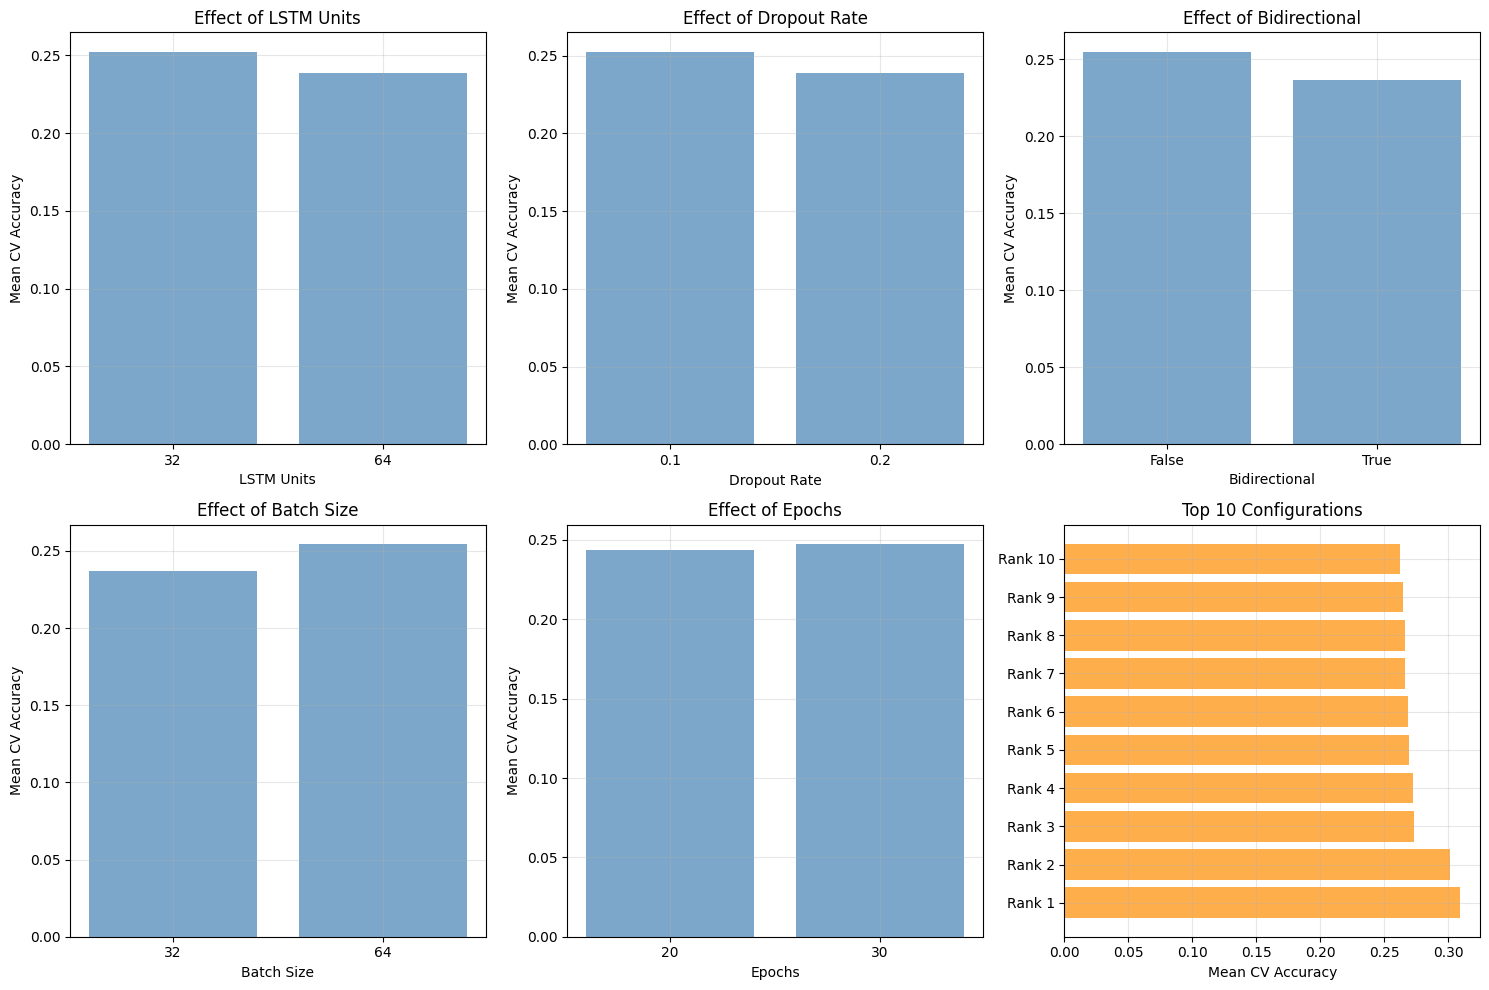


✅ Best Configuration:
   Accuracy: 0.3093
   batch_size: 64
   epochs: 30
   model__bidirectional: False
   model__dropout_rate: 0.1
   model__units: 32


In [22]:
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\n✅ Best Score: {grid_result.best_score_:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in grid_result.best_params_.items():
    print(f"   {param}: {value}")

print("\n📊 Top 5 Configurations:")
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = results_df.sort_values('rank_test_score')
for idx, row in results_df.head(5).iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"      Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"      Params: {row['params']}")

# Visualize Grid Search Results
print("="*60)
print("GRID SEARCH RESULTS VISUALIZATION")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame(grid_result.cv_results_)

# Plot 1: Mean Test Score Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Hyperparameter vs Score plots (khusus LSTM)
params_to_plot = ['param_model__units', 'param_model__dropout_rate', 'param_model__bidirectional', 
                  'param_batch_size', 'param_epochs']
titles = ['LSTM Units', 'Dropout Rate', 'Bidirectional', 
          'Batch Size', 'Epochs']

for idx, (param, title) in enumerate(zip(params_to_plot, titles)):
    ax = axes[idx // 3, idx % 3]
    grouped = results_df.groupby(param)['mean_test_score'].mean()
    ax.bar(range(len(grouped)), grouped.values, color='steelblue', alpha=0.7)
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels([str(x) for x in grouped.index])
    ax.set_xlabel(title)
    ax.set_ylabel('Mean CV Accuracy')
    ax.set_title(f'Effect of {title}')
    ax.grid(True, alpha=0.3)

# Plot 6: Top 10 Configurations
ax = axes[1, 2]
top_10 = results_df.nsmallest(10, 'rank_test_score')
ax.barh(range(10), top_10['mean_test_score'].values, color='darkorange', alpha=0.7)
ax.set_yticks(range(10))
ax.set_yticklabels([f"Rank {int(r)}" for r in top_10['rank_test_score']])
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Top 10 Configurations')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/LSTM/grid_search_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best parameters summary
print(f"\n✅ Best Configuration:")
print(f"   Accuracy: {grid_result.best_score_:.4f}")
for param, value in grid_result.best_params_.items():
    print(f"   {param}: {value}")


### Extract Feature 

In [23]:
# Extract features from best Grid Search LSTM model for XGBoost
best_lstm_model = grid_result.best_estimator_.model_

# Build feature extractor from the second-to-last layer
gs_feature_extractor = Model(
    inputs=best_lstm_model.inputs,
    outputs=best_lstm_model.layers[-2].output
)

# Extract features
print("Extracting features from Grid Search LSTM model...")
X_train_weights_gs = gs_feature_extractor.predict(X_train_seq, verbose=0)
X_test_weights_gs = gs_feature_extractor.predict(X_test_seq, verbose=0)

print("✅ Features extracted from Grid Search LSTM model")
print(f"   Train: {X_train_weights_gs.shape}")
print(f"   Test: {X_test_weights_gs.shape}")

Extracting features from Grid Search LSTM model...
✅ Features extracted from Grid Search LSTM model
   Train: (23991, 16)
   Test: (14391, 16)


### Optuna

#### Model

In [24]:
def create_lstm_model_optuna(trial):
    """
    Create LSTM model with Optuna hyperparameters
    """
    # Hyperparameters to tune
    units = trial.suggest_categorical('units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model
    inputs = Input(shape=(SEQUENCE_LENGTH, 5))
    x = tf.keras.layers.Masking()(inputs)
    if bidirectional:
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False))(x)
    else:
        x = tf.keras.layers.LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(max(8, units // 2), activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("✅ LSTM model for Optuna defined")


✅ LSTM model for Optuna defined


#### Running

In [25]:
def objective(trial):
    """
    Optuna objective function for LSTM hyperparameter tuning
    """
    # Hyperparameters to tune
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 20, 50)
    
    # Create model
    model = create_lstm_model_optuna(trial)
    
    # Class weights
    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
    class_weight_dict = dict(enumerate(class_weights_array))
    
    # Train model
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=batch_size,
        epochs=epochs,
        class_weight=class_weight_dict,
        validation_split=0.2,
        verbose=0,
        callbacks=[TFKerasPruningCallback(trial, 'val_accuracy')]
    )
    
    return history.history['val_accuracy'][-1]

# Run Optuna optimization
print("="*60)
print("OPTUNA HYPERPARAMETER TUNING - LSTM")
print("="*60)
print("\nStarting Optuna optimization...")

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n" + "="*60)
print("OPTUNA RESULTS")
print("="*60)
print(f"\n✅ Best Accuracy: {study.best_value:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

[I 2025-12-10 11:39:28,539] A new study created in memory with name: no-name-102a8848-06b9-462f-822f-70f905cc2eb9


OPTUNA HYPERPARAMETER TUNING - LSTM

Starting Optuna optimization...


  0%|          | 0/30 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.00062513:   3%|▎         | 1/30 [04:32<2:11:30, 272.10s/it]

[I 2025-12-10 11:44:00,612] Trial 0 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 32, 'epochs': 45, 'units': 128, 'dropout_rate': 0.21720800129617499, 'bidirectional': False, 'learning_rate': 0.0059916595311227975}. Best is trial 0 with value: 0.0006251302547752857.


Best trial: 1. Best value: 0.000833507:   7%|▋         | 2/30 [11:09<2:41:16, 345.58s/it]

[I 2025-12-10 11:50:37,569] Trial 1 finished with value: 0.000833506986964494 and parameters: {'batch_size': 32, 'epochs': 38, 'units': 128, 'dropout_rate': 0.18148239922146897, 'bidirectional': True, 'learning_rate': 0.00023571139294806216}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  10%|█         | 3/30 [12:07<1:36:35, 214.66s/it]

[I 2025-12-10 11:51:36,538] Trial 2 finished with value: 0.000833506986964494 and parameters: {'batch_size': 128, 'epochs': 29, 'units': 32, 'dropout_rate': 0.21049895587484554, 'bidirectional': False, 'learning_rate': 0.0006313738279011101}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  13%|█▎        | 4/30 [13:14<1:07:39, 156.15s/it]

[I 2025-12-10 11:52:42,956] Trial 3 finished with value: 0.0002083767467411235 and parameters: {'batch_size': 128, 'epochs': 37, 'units': 32, 'dropout_rate': 0.3431477869621643, 'bidirectional': True, 'learning_rate': 0.00016605213257106998}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  17%|█▋        | 5/30 [15:30<1:02:05, 149.03s/it]

[I 2025-12-10 11:54:59,390] Trial 4 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 128, 'epochs': 37, 'units': 128, 'dropout_rate': 0.100508044572021, 'bidirectional': False, 'learning_rate': 0.0003258258049972325}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  20%|██        | 6/30 [19:03<1:08:19, 170.80s/it]

[I 2025-12-10 11:58:32,394] Trial 5 finished with value: 0.0002083767467411235 and parameters: {'batch_size': 64, 'epochs': 50, 'units': 32, 'dropout_rate': 0.3535570446762285, 'bidirectional': True, 'learning_rate': 0.000507312232792052}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  23%|██▎       | 7/30 [19:15<45:33, 118.84s/it]  

[I 2025-12-10 11:58:44,322] Trial 6 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  27%|██▋       | 8/30 [19:20<30:13, 82.44s/it] 

[I 2025-12-10 11:58:48,834] Trial 7 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  30%|███       | 9/30 [19:26<20:32, 58.69s/it]

[I 2025-12-10 11:58:55,287] Trial 8 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  33%|███▎      | 10/30 [19:33<14:12, 42.62s/it]

[I 2025-12-10 11:59:01,947] Trial 9 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  37%|███▋      | 11/30 [19:51<11:04, 35.00s/it]

[I 2025-12-10 11:59:19,644] Trial 10 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  40%|████      | 12/30 [21:03<13:55, 46.43s/it]

[I 2025-12-10 12:00:32,177] Trial 11 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 128, 'epochs': 30, 'units': 32, 'dropout_rate': 0.18819451313606989, 'bidirectional': True, 'learning_rate': 0.0005438403700627503}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  43%|████▎     | 13/30 [24:09<25:08, 88.72s/it]

[I 2025-12-10 12:03:38,217] Trial 12 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 32, 'epochs': 30, 'units': 32, 'dropout_rate': 0.17498853779326984, 'bidirectional': True, 'learning_rate': 0.002497374308746288}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  47%|████▋     | 14/30 [24:58<20:28, 76.76s/it]

[I 2025-12-10 12:04:27,370] Trial 13 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 128, 'epochs': 31, 'units': 32, 'dropout_rate': 0.2609937029009855, 'bidirectional': False, 'learning_rate': 0.0003523561044232302}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  50%|█████     | 15/30 [25:08<14:09, 56.61s/it]

[I 2025-12-10 12:04:37,278] Trial 14 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  53%|█████▎    | 16/30 [25:26<10:28, 44.86s/it]

[I 2025-12-10 12:04:54,869] Trial 15 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  57%|█████▋    | 17/30 [26:12<09:48, 45.30s/it]

[I 2025-12-10 12:05:41,176] Trial 16 finished with value: 0.0006251302547752857 and parameters: {'batch_size': 128, 'epochs': 25, 'units': 32, 'dropout_rate': 0.22119994297965187, 'bidirectional': True, 'learning_rate': 0.00010517386538081314}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  60%|██████    | 18/30 [26:17<06:39, 33.28s/it]

[I 2025-12-10 12:05:46,489] Trial 17 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  63%|██████▎   | 19/30 [26:27<04:48, 26.27s/it]

[I 2025-12-10 12:05:56,403] Trial 18 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  67%|██████▋   | 20/30 [26:39<03:37, 21.78s/it]

[I 2025-12-10 12:06:07,721] Trial 19 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  70%|███████   | 21/30 [26:50<02:47, 18.57s/it]

[I 2025-12-10 12:06:18,832] Trial 20 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  73%|███████▎  | 22/30 [34:00<18:57, 142.20s/it]

[I 2025-12-10 12:13:29,213] Trial 21 finished with value: 0.000833506986964494 and parameters: {'batch_size': 32, 'epochs': 48, 'units': 128, 'dropout_rate': 0.21738226055736207, 'bidirectional': False, 'learning_rate': 0.005285791165977687}. Best is trial 1 with value: 0.000833506986964494.


Best trial: 1. Best value: 0.000833507:  77%|███████▋  | 23/30 [34:18<12:13, 104.78s/it]

[I 2025-12-10 12:13:46,841] Trial 22 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  80%|████████  | 24/30 [34:33<07:47, 77.84s/it] 

[I 2025-12-10 12:14:01,835] Trial 23 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  83%|████████▎ | 25/30 [34:47<04:54, 58.80s/it]

[I 2025-12-10 12:14:16,224] Trial 24 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  87%|████████▋ | 26/30 [34:59<02:58, 44.68s/it]

[I 2025-12-10 12:14:27,937] Trial 25 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  90%|█████████ | 27/30 [35:14<01:47, 35.77s/it]

[I 2025-12-10 12:14:42,923] Trial 26 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  93%|█████████▎| 28/30 [35:29<00:58, 29.46s/it]

[I 2025-12-10 12:14:57,681] Trial 27 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507:  97%|█████████▋| 29/30 [35:42<00:24, 24.73s/it]

[I 2025-12-10 12:15:11,371] Trial 28 pruned. Trial was pruned at epoch 0.


Best trial: 1. Best value: 0.000833507: 100%|██████████| 30/30 [35:50<00:00, 71.70s/it]

[I 2025-12-10 12:15:19,403] Trial 29 pruned. Trial was pruned at epoch 0.

OPTUNA RESULTS

✅ Best Accuracy: 0.0008

📊 Best Hyperparameters:
   batch_size: 32
   epochs: 38
   units: 128
   dropout_rate: 0.18148239922146897
   bidirectional: True
   learning_rate: 0.00023571139294806216


In [26]:
# Save best Optuna LSTM model
os.makedirs('models/LSTM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

# Rebuild model with best params and retrain on full data
best_trial = study.best_trial
best_model = create_lstm_model_optuna(best_trial)

# Class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))

# Retrain on full data
best_model.fit(
    X_train_seq, y_train_seq,
    batch_size=best_trial.params['batch_size'],
    epochs=best_trial.params['epochs'],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.9525 - loss: 0.1415
Epoch 2/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9906 - loss: 0.0315
Epoch 3/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9962 - loss: 0.0126
Epoch 4/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9967 - loss: 0.0109
Epoch 5/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9972 - loss: 0.0092
Epoch 6/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9979 - loss: 0.0067
Epoch 7/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9980 - loss: 0.0056
Epoch 8/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 9/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9988 - loss: 0.0038
Epoch 10/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 11/38
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9992 - loss: 0.0025
Epoch 12/38
750/750 ━━━━━━━━━━━━━

#### Save Model

In [27]:
import joblib
import os
from datetime import datetime as dt


BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'LSTM_RF_optuna_{timestamp}.joblib')

joblib.dump(best_model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\LSTM\LSTM_RF_optuna_10122025_122323.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Optuna

OPTUNA RESULTS VISUALIZATION


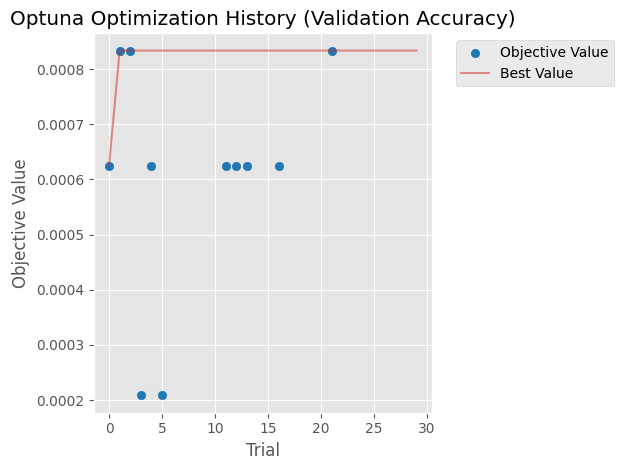

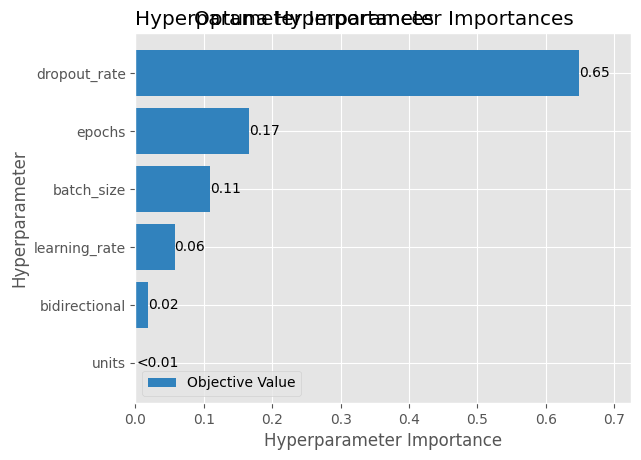


✅ Best Optuna Configuration:
   Accuracy: 0.0008
   batch_size: 32
   epochs: 38
   units: 128
   dropout_rate: 0.18148239922146897
   bidirectional: True
   learning_rate: 0.00023571139294806216


In [28]:
# Visualisasi hasil Optuna LSTM

print("="*60)
print("OPTUNA RESULTS VISUALIZATION")
print("="*60)

# Plot optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optuna Optimization History (Validation Accuracy)")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Optuna Hyperparameter Importances")
plt.show()

# Print best trial summary
print(f"\n✅ Best Optuna Configuration:")
print(f"   Accuracy: {study.best_value:.4f}")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

#### Extraxt Feature

In [29]:
# Extract features from best Optuna Transformer model for XGBoost
# Build feature extractor from the second-to-last layer
optuna_feature_extractor = Model(
    inputs=best_model.inputs,
    outputs=best_model.layers[-2].output
)

print("Extracting features from Optuna LSTM model...")
X_train_weights_optuna = optuna_feature_extractor.predict(X_train_seq, verbose=0)
X_test_weights_optuna = optuna_feature_extractor.predict(X_test_seq, verbose=0)

print("✅ Features extracted from Optuna LSTM model")
print(f"   Train: {X_train_weights_optuna.shape}")
print(f"   Test: {X_test_weights_optuna.shape}")

Extracting features from Optuna LSTM model...
✅ Features extracted from Optuna LSTM model
   Train: (23991, 64)
   Test: (14391, 64)


### Default

#### Model

In [30]:
# Build default LSTM model
def build_lstm_model_default(n_timesteps=SEQUENCE_LENGTH, n_features=5, units=64, dropout_rate=0.2, bidirectional=False):
    """
    Build default LSTM model.
    """
    inputs = Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.Masking()(inputs)
    if bidirectional:
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False))(x)
    else:
        x = tf.keras.layers.LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(max(8, units // 2), activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("✅ Default LSTM model defined")

✅ Default LSTM model defined


#### Training

In [31]:
# Build default LSTM model
model = build_lstm_model_default(
    n_timesteps=SEQUENCE_LENGTH,
    n_features=5,
    units=64,
    dropout_rate=0.2,
    bidirectional=False
)

print("Model Architecture:")
model.summary()

# Train model (tanpa validation - sesuai jurnal)
print("\nTraining Default LSTM Model...")

# Class weights untuk handle imbalance
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weight_dict = dict(enumerate(class_weights_array))
print(f"Class weights: {class_weight_dict}")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)

print(f"\n✅ Training completed.")
print(f"   Final accuracy: {history.history['accuracy'][-1]:.4f}")

Model Architecture:


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_32        │ (None, 10, 5)     │          0 │ input_layer_32[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_32          │ (None, 10, 5)     │          0 │ input_layer_32[0… │
│ (Masking)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_32 (Any)        │ (None, 10)        │          0 │ not_equal_32[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 64)        │     17,920 │ masking_32[0][0], │
│                     │                   │            │ any_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 64)        │          0 │ lstm_32[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 32)        │      2,080 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 32)        │          0 │ dense_64[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 1)         │         33 │ dropout_65[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)


Training Default LSTM Model...
Class weights: {0: np.float64(0.999625), 1: np.float64(1.0003752814610958)}
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9460 - loss: 0.1479
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9863 - loss: 0.0489
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9940 - loss: 0.0202
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9975 - loss: 0.0094
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9977 - loss: 0.0093
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9970 - loss: 0.0089
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9977 - loss: 0.0077
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9987 - loss: 0.0044
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9990 - loss: 0.0034
Epoch 11/50
375/375 

#### Save Model

In [32]:
# Save default LSTM model
os.makedirs('models/LSTM', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

model.save(f'models/LSTM/lstm_rf_default_{timestamp}.keras')

print("✅ Default LSTM model saved!")
print(f"   Model: models/LSTM/lstm_rf_default_{timestamp}.keras")

✅ Default LSTM model saved!
   Model: models/LSTM/lstm_rf_default_10122025_122735.keras


In [33]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'LSTM')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_lstm_default_{timestamp}.joblib')

joblib.dump(model, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\LSTM\rf_lstm_default_10122025_122735.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

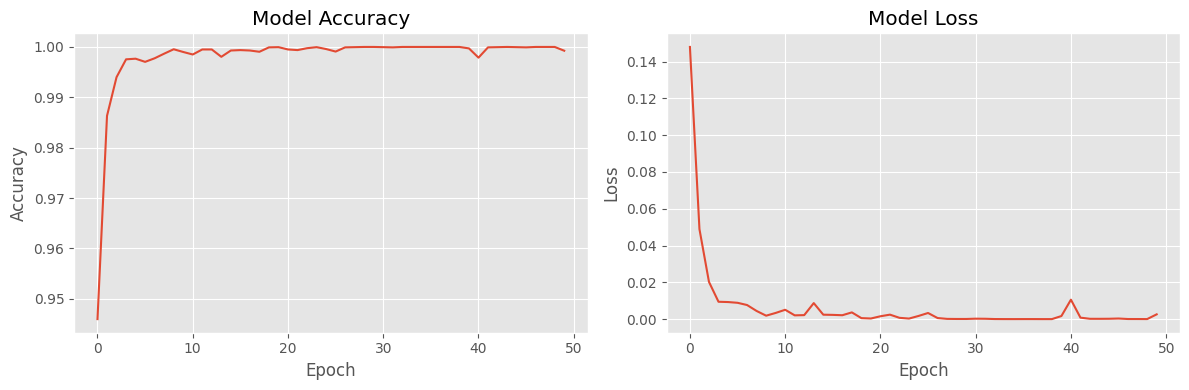

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

#### Extract Features 

In [35]:
lstm_default_feature_extractor = Model(
    inputs=model.inputs, 
    outputs=model.layers[-2].output 
)

# Extract features
print("Extracting features from LSTM model...")
X_train_weights_default = lstm_default_feature_extractor.predict(X_train_seq, verbose=0)
X_test_weights_default = lstm_default_feature_extractor.predict(X_test_seq, verbose=0)

print("✅ Features extracted from LSTM model")
print(f"   Train: {X_train_weights_default.shape}")
print(f"   Test: {X_test_weights_default.shape}")

Extracting features from LSTM model...
✅ Features extracted from LSTM model
   Train: (23991, 32)
   Test: (14391, 32)


# Random Forest Classifier 

### Grid search

#### Model

In [36]:
# Parameter grid untuk Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)


#### Running

In [37]:
print("Training Random Forest GridSearchCV with features from Grid Search LSTM...")
grid_rf.fit(X_train_weights_gs, y_train_seq)
print("✅ GridSearchCV completed")
print(f"Best params: {grid_rf.best_params_}")
print(f"Best score: {grid_rf.best_score_:.4f}")

Training Random Forest GridSearchCV with features from Grid Search LSTM...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


✅ GridSearchCV completed
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 1.0000


#### Save Model

In [38]:
# Save best Random Forest model from GridSearchCV
os.makedirs('models/RF', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

joblib.dump(grid_rf.best_estimator_, f'models/RF/rf_grid_{timestamp}.joblib')

print("✅ Best Random Forest model from GridSearchCV saved!")
print(f"   Model: models/RF/rf_grid_{timestamp}.joblib")

✅ Best Random Forest model from GridSearchCV saved!
   Model: models/RF/rf_grid_10122025_123037.joblib


In [39]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'RandomForest')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_lstm_grid_{timestamp}.joblib')

joblib.dump(grid_rf.best_estimator_, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\RandomForest\rf_lstm_grid_10122025_123038.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Grid Search

RANDOM FOREST GRID SEARCH RESULTS

✅ Best Accuracy: 1.0000

📊 Best Hyperparameters:
   max_depth: None
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 100

📊 Top 5 Configurations:

   Rank 1:
      Accuracy: 1.0000 (+/- 0.0000)
      Params  : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

   Rank 1:
      Accuracy: 1.0000 (+/- 0.0000)
      Params  : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

   Rank 1:
      Accuracy: 1.0000 (+/- 0.0000)
      Params  : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

   Rank 1:
      Accuracy: 1.0000 (+/- 0.0000)
      Params  : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

   Rank 1:
      Accuracy: 1.0000 (+/- 0.0000)
      Params  : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

CONFUSION MATRIX & METRICS

✅ Performance M

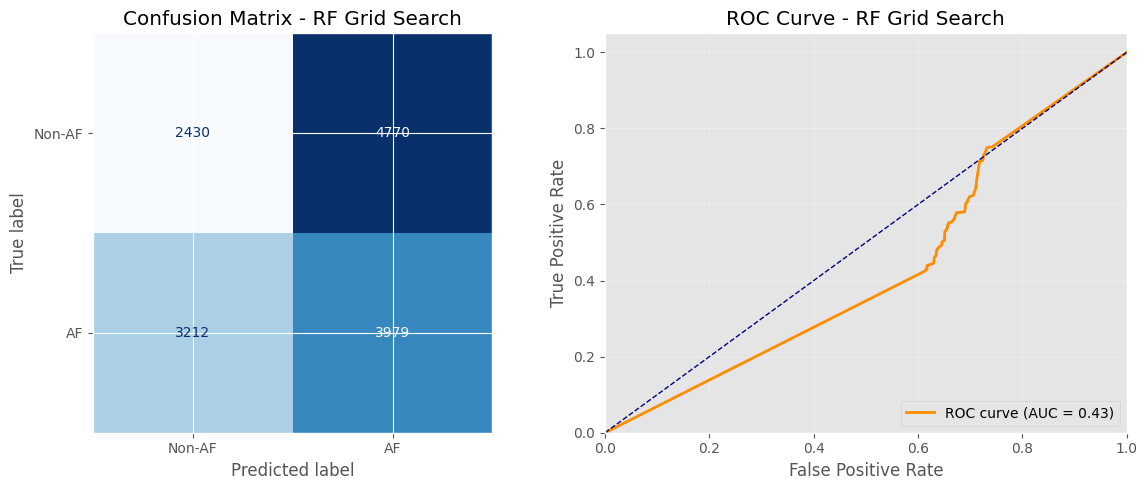


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Non-AF       0.43      0.34      0.38      7200
          AF       0.45      0.55      0.50      7191

    accuracy                           0.45     14391
   macro avg       0.44      0.45      0.44     14391
weighted avg       0.44      0.45      0.44     14391



In [40]:
print("="*60)
print("RANDOM FOREST GRID SEARCH RESULTS")
print("="*60)

# Best Score & Hyperparameters
print(f"\n✅ Best Accuracy: {grid_rf.best_score_:.4f}")
print(f"\n📊 Best Hyperparameters:")
for param, value in grid_rf.best_params_.items():
    print(f"   {param}: {value}")

# Top 5 Configurations
results_rf_df = pd.DataFrame(grid_rf.cv_results_).sort_values('rank_test_score')
print("\n📊 Top 5 Configurations:")
for idx, row in results_rf_df.head(5).iterrows():
    print(f"\n   Rank {int(row['rank_test_score'])}:")
    print(f"      Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"      Params  : {row['params']}")

print("\n" + "="*60)
print("CONFUSION MATRIX & METRICS")
print("="*60)

# Metrics
y_pred_rf = grid_rf.predict(X_test_weights_gs)
y_prob_rf = grid_rf.predict_proba(X_test_weights_gs)[:, 1]
acc_rf = accuracy_score(y_test_seq, y_pred_rf)
prec_rf = precision_score(y_test_seq, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test_seq, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test_seq, y_pred_rf, zero_division=0)
rocauc_rf = roc_auc_score(y_test_seq, y_prob_rf) if len(np.unique(y_pred_rf)) > 1 else 0.5

print(f"\n✅ Performance Metrics:")
print(f"   Accuracy : {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"   Precision: {prec_rf:.4f} ({prec_rf*100:.2f}%)")
print(f"   Recall   : {recall_rf:.4f} ({recall_rf*100:.2f}%)")
print(f"   F1 Score : {f1_rf:.4f} ({f1_rf*100:.2f}%)")
print(f"   ROC AUC  : {rocauc_rf:.4f} ({rocauc_rf*100:.2f}%)")

# Confusion Matrix & ROC Curve side by side
cm_rf = confusion_matrix(y_test_seq, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Non-AF', 'AF'])
disp_rf.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - RF Grid Search')

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rocauc_rf:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - RF Grid Search')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test_seq, y_pred_rf, target_names=['Non-AF', 'AF'], zero_division=0))

### Optuna

#### Model

In [41]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train_weights_optuna, y_train_seq)
    preds = rf.predict(X_test_weights_optuna)
    return accuracy_score(y_test_seq, preds)

study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print("✅ Optuna Random Forest completed")
print(f"Best Accuracy: {study_rf.best_value:.4f}")
print("Best Params:", study_rf.best_params)

[I 2025-12-10 12:30:39,035] A new study created in memory with name: no-name-f63548b5-70fe-4e51-a5d7-6eadaf4a341f
Best trial: 0. Best value: 0.453756:   3%|▎         | 1/30 [00:07<03:29,  7.24s/it]

[I 2025-12-10 12:30:46,279] Trial 0 finished with value: 0.45375581960947814 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:   7%|▋         | 2/30 [00:11<02:39,  5.69s/it]

[I 2025-12-10 12:30:50,888] Trial 1 finished with value: 0.4509068167604753 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:  10%|█         | 3/30 [00:23<03:44,  8.33s/it]

[I 2025-12-10 12:31:02,360] Trial 2 finished with value: 0.45076784101174344 and parameters: {'n_estimators': 250, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:  13%|█▎        | 4/30 [00:30<03:28,  8.01s/it]

[I 2025-12-10 12:31:09,889] Trial 3 finished with value: 0.4527829893683552 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:  17%|█▋        | 5/30 [00:36<02:56,  7.05s/it]

[I 2025-12-10 12:31:15,232] Trial 4 finished with value: 0.45347786811201446 and parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:  20%|██        | 6/30 [00:41<02:37,  6.54s/it]

[I 2025-12-10 12:31:20,784] Trial 5 finished with value: 0.45243554999652563 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 0. Best value: 0.453756:  23%|██▎       | 7/30 [00:49<02:35,  6.78s/it]

[I 2025-12-10 12:31:28,055] Trial 6 finished with value: 0.45347786811201446 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.45375581960947814.


Best trial: 7. Best value: 0.455701:  27%|██▋       | 8/30 [00:52<02:03,  5.60s/it]

[I 2025-12-10 12:31:31,124] Trial 7 finished with value: 0.455701480091724 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  30%|███       | 9/30 [00:55<01:43,  4.92s/it]

[I 2025-12-10 12:31:34,549] Trial 8 finished with value: 0.45375581960947814 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  33%|███▎      | 10/30 [01:03<01:56,  5.81s/it]

[I 2025-12-10 12:31:42,373] Trial 9 finished with value: 0.4538253074838441 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  37%|███▋      | 11/30 [01:15<02:28,  7.83s/it]

[I 2025-12-10 12:31:54,754] Trial 10 finished with value: 0.45257452574525747 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  40%|████      | 12/30 [01:24<02:27,  8.19s/it]

[I 2025-12-10 12:32:03,761] Trial 11 finished with value: 0.45410325898130777 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  43%|████▎     | 13/30 [01:36<02:35,  9.15s/it]

[I 2025-12-10 12:32:15,128] Trial 12 finished with value: 0.4539642832325759 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  47%|████▋     | 14/30 [01:44<02:22,  8.94s/it]

[I 2025-12-10 12:32:23,569] Trial 13 finished with value: 0.45528455284552843 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  50%|█████     | 15/30 [01:52<02:11,  8.77s/it]

[I 2025-12-10 12:32:31,945] Trial 14 finished with value: 0.45528455284552843 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  53%|█████▎    | 16/30 [01:56<01:40,  7.21s/it]

[I 2025-12-10 12:32:35,531] Trial 15 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  57%|█████▋    | 17/30 [01:59<01:19,  6.09s/it]

[I 2025-12-10 12:32:39,021] Trial 16 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  60%|██████    | 18/30 [02:03<01:03,  5.33s/it]

[I 2025-12-10 12:32:42,589] Trial 17 finished with value: 0.45326940448891667 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  63%|██████▎   | 19/30 [02:11<01:05,  5.98s/it]

[I 2025-12-10 12:32:50,083] Trial 18 finished with value: 0.4504204016399138 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  67%|██████▋   | 20/30 [02:14<00:51,  5.15s/it]

[I 2025-12-10 12:32:53,299] Trial 19 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  70%|███████   | 21/30 [02:19<00:45,  5.06s/it]

[I 2025-12-10 12:32:58,146] Trial 20 finished with value: 0.4534083802376485 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  73%|███████▎  | 22/30 [02:22<00:37,  4.67s/it]

[I 2025-12-10 12:33:01,899] Trial 21 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  77%|███████▋  | 23/30 [02:26<00:30,  4.39s/it]

[I 2025-12-10 12:33:05,642] Trial 22 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  80%|████████  | 24/30 [02:30<00:25,  4.30s/it]

[I 2025-12-10 12:33:09,735] Trial 23 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  83%|████████▎ | 25/30 [02:36<00:23,  4.75s/it]

[I 2025-12-10 12:33:15,548] Trial 24 finished with value: 0.45243554999652563 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  87%|████████▋ | 26/30 [02:40<00:17,  4.48s/it]

[I 2025-12-10 12:33:19,388] Trial 25 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  90%|█████████ | 27/30 [02:47<00:16,  5.40s/it]

[I 2025-12-10 12:33:26,933] Trial 26 finished with value: 0.45306094086581894 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  93%|█████████▎| 28/30 [02:51<00:09,  4.76s/it]

[I 2025-12-10 12:33:30,200] Trial 27 finished with value: 0.4554930164686262 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701:  97%|█████████▋| 29/30 [02:58<00:05,  5.64s/it]

[I 2025-12-10 12:33:37,886] Trial 28 finished with value: 0.45347786811201446 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 7 with value: 0.455701480091724.


Best trial: 7. Best value: 0.455701: 100%|██████████| 30/30 [03:07<00:00,  6.25s/it]

[I 2025-12-10 12:33:46,479] Trial 29 finished with value: 0.45306094086581894 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 7 with value: 0.455701480091724.
✅ Optuna Random Forest completed
Best Accuracy: 0.4557
Best Params: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': True}


#### Running

In [42]:
# Train Random Forest with Optuna best parameters using features from Optuna Transformer
rf_optuna = RandomForestClassifier(**study_rf.best_params, random_state=42)

print("Training Random Forest with Optuna best parameters (Optuna LSTM features)...")
rf_optuna.fit(X_train_weights_optuna, y_train_seq)
print("✅ Random Forest (Optuna) trained")

Training Random Forest with Optuna best parameters (Optuna LSTM features)...


✅ Random Forest (Optuna) trained


### Save Model

In [43]:
# Save Random Forest model (Optuna)
os.makedirs('models/RF', exist_ok=True)
timestamp = dt.now().strftime('%d%m%Y_%H%M%S')

joblib.dump(rf_optuna, f'models/RF/rf_optuna_{timestamp}.joblib')

print("✅ Optuna Random Forest model saved!")
print(f"   Model: models/RF/rf_optuna_{timestamp}.joblib")

✅ Optuna Random Forest model saved!
   Model: models/RF/rf_optuna_10122025_123350.joblib


In [44]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'RandomForest')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_lstm_optuna_{timestamp}.joblib')

joblib.dump(rf_optuna, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\RandomForest\rf_lstm_optuna_10122025_123350.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Optuna

HYBRID MODEL EVALUATION (Optuna LSTM + Random Forest)
Dataset: MIMIC Perform AF

📊 Performance Metrics:
   Accuracy : 0.4557 (45.57%)
   Precision: 0.4651 (46.51%)
   Recall   : 0.5944 (59.44%)
   F1 Score : 0.5218 (52.18%)
   ROC AUC  : 0.4839 (48.39%)


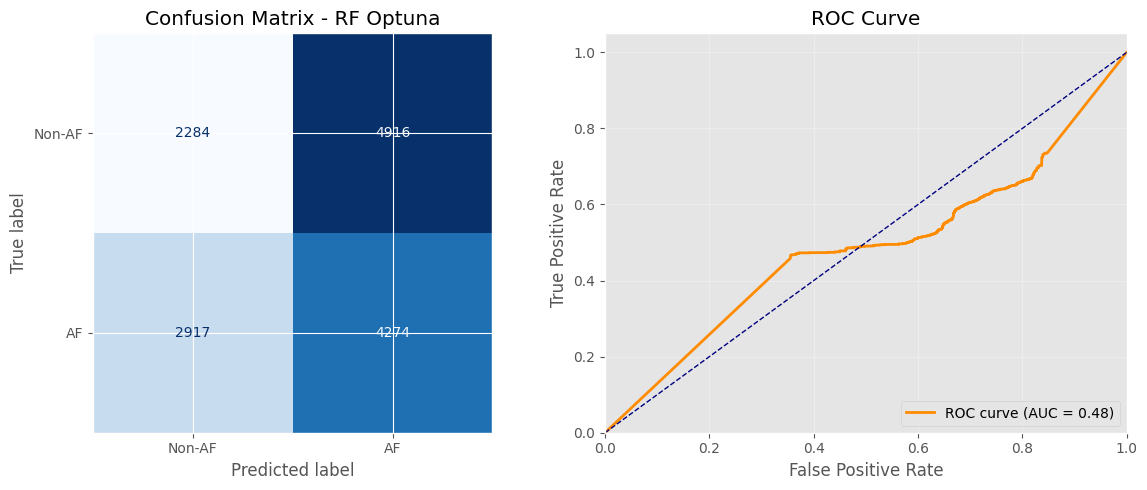


Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.44      0.32      0.37      7200
          AF       0.47      0.59      0.52      7191

    accuracy                           0.46     14391
   macro avg       0.45      0.46      0.45     14391
weighted avg       0.45      0.46      0.45     14391



In [45]:
# Evaluate Random Forest Optuna model
y_prob_optuna = rf_optuna.predict_proba(X_test_weights_optuna)[:, 1]
y_pred_optuna = rf_optuna.predict(X_test_weights_optuna)

# Metrics
acc_optuna = accuracy_score(y_test_seq, y_pred_optuna)
prec_optuna = precision_score(y_test_seq, y_pred_optuna, zero_division=0)
recall_optuna = recall_score(y_test_seq, y_pred_optuna, zero_division=0)
f1_optuna = f1_score(y_test_seq, y_pred_optuna, zero_division=0)
roauc_optuna = roc_auc_score(y_test_seq, y_prob_optuna) if len(np.unique(y_pred_optuna)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (Optuna LSTM + Random Forest)")
print("Dataset: MIMIC Perform AF")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc_optuna:.4f} ({acc_optuna*100:.2f}%)")
print(f"   Precision: {prec_optuna:.4f} ({prec_optuna*100:.2f}%)")
print(f"   Recall   : {recall_optuna:.4f} ({recall_optuna*100:.2f}%)")
print(f"   F1 Score : {f1_optuna:.4f} ({f1_optuna*100:.2f}%)")
print(f"   ROC AUC  : {roauc_optuna:.4f} ({roauc_optuna*100:.2f}%)")

# Confusion Matrix & ROC Curve
cm_optuna = confusion_matrix(y_test_seq, y_pred_optuna)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_optuna)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_optuna = ConfusionMatrixDisplay(confusion_matrix=cm_optuna, display_labels=['Non-AF', 'AF'])
disp_optuna.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - RF Optuna')

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roauc_optuna:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred_optuna, target_names=['Non-AF', 'AF'], zero_division=0))

### Default

#### Model

In [46]:
rf_default = RandomForestClassifier(random_state=42)

#### Running

In [47]:
print("Training Random Forest Default (fitur ekstraksi default)...")
rf_default.fit(X_train_weights_default, y_train_seq)
print("✅ Random Forest Default trained")

Training Random Forest Default (fitur ekstraksi default)...
✅ Random Forest Default trained


#### Save Model

In [48]:
import joblib
import os
from datetime import datetime as dt

BASE_DIR = r"C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM"
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'RandomForest')
os.makedirs(MODEL_DIR, exist_ok=True)

timestamp = dt.now().strftime('%d%m%Y_%H%M%S')
file_path = os.path.join(MODEL_DIR, f'rf_lstm_default_{timestamp}.joblib')

joblib.dump(rf_default, file_path)

print(f"✅ Model tersimpan di jalur ABSOLUT:")
print(f"   {file_path}")

# Verifikasi keberadaan berkas secara instan
if os.path.exists(file_path):
    print("✅ Verifikasi: Berkas ditemukan di disk.")
else:
    print("❌ Verifikasi: Gagal menemukan berkas di jalur absolut yang ditentukan.")

✅ Model tersimpan di jalur ABSOLUT:
   C:\SEMESTER 3\FINAL PROJECT\DATMIN ML\ngoding\FP_MLxDM\models\RandomForest\rf_lstm_default_10122025_123354.joblib
✅ Verifikasi: Berkas ditemukan di disk.


#### Hasil Default

HYBRID MODEL EVALUATION (Default LSTM + Random Forest)
Dataset: MIMIC Perform AF

📊 Performance Metrics:
   Accuracy : 0.5071 (50.71%)
   Precision: 0.5051 (50.51%)
   Recall   : 0.6747 (67.47%)
   F1 Score : 0.5777 (57.77%)
   ROC AUC  : 0.5131 (51.31%)


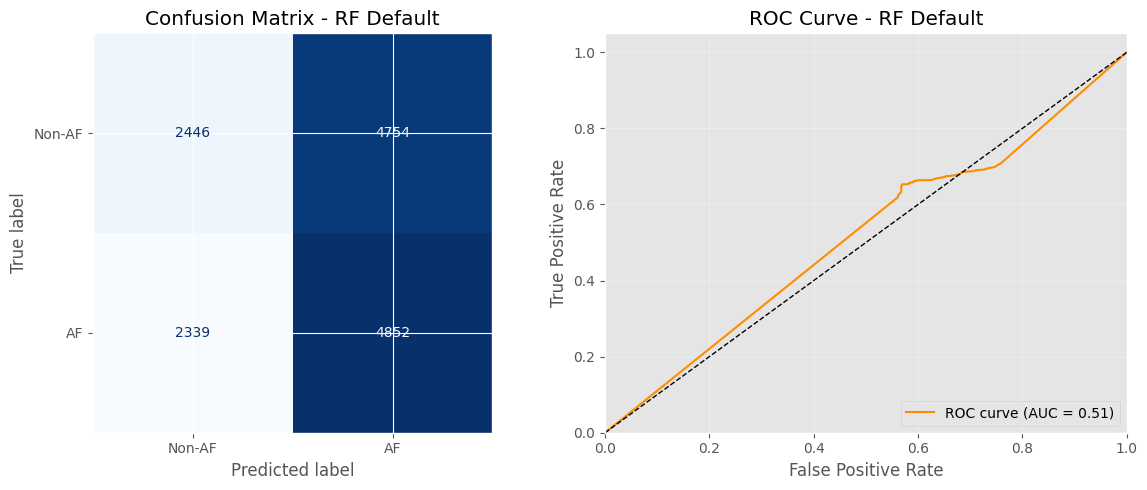


Classification Report:
              precision    recall  f1-score   support

      Non-AF       0.51      0.34      0.41      7200
          AF       0.51      0.67      0.58      7191

    accuracy                           0.51     14391
   macro avg       0.51      0.51      0.49     14391
weighted avg       0.51      0.51      0.49     14391



In [49]:
# Evaluate Random Forest Default model 

y_prob_default = rf_default.predict_proba(X_test_weights_default)[:, 1]
y_pred_default = rf_default.predict(X_test_weights_default)

# Metrics
acc_default = accuracy_score(y_test_seq, y_pred_default)
prec_default = precision_score(y_test_seq, y_pred_default, zero_division=0)
recall_default = recall_score(y_test_seq, y_pred_default, zero_division=0)
f1_default = f1_score(y_test_seq, y_pred_default, zero_division=0)
rocauc_default = roc_auc_score(y_test_seq, y_prob_default) if len(np.unique(y_pred_default)) > 1 else 0.5

print("="*60)
print("HYBRID MODEL EVALUATION (Default LSTM + Random Forest)")
print("Dataset: MIMIC Perform AF")
print("="*60)
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy : {acc_default:.4f} ({acc_default*100:.2f}%)")
print(f"   Precision: {prec_default:.4f} ({prec_default*100:.2f}%)")
print(f"   Recall   : {recall_default:.4f} ({recall_default*100:.2f}%)")
print(f"   F1 Score : {f1_default:.4f} ({f1_default*100:.2f}%)")
print(f"   ROC AUC  : {rocauc_default:.4f} ({rocauc_default*100:.2f}%)")

# Confusion Matrix & ROC Curve side by side
cm_default = confusion_matrix(y_test_seq, y_pred_default)
fpr, tpr, thresholds = roc_curve(y_test_seq, y_prob_default)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Non-AF', 'AF'])
disp_default.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix - RF Default')

# ROC Curve
axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {rocauc_default:.2f})', color='darkorange')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - RF Default')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test_seq, y_pred_default, target_names=['Non-AF', 'AF'], zero_division=0))

# Model Evaluation

### Perbandingan Metrics

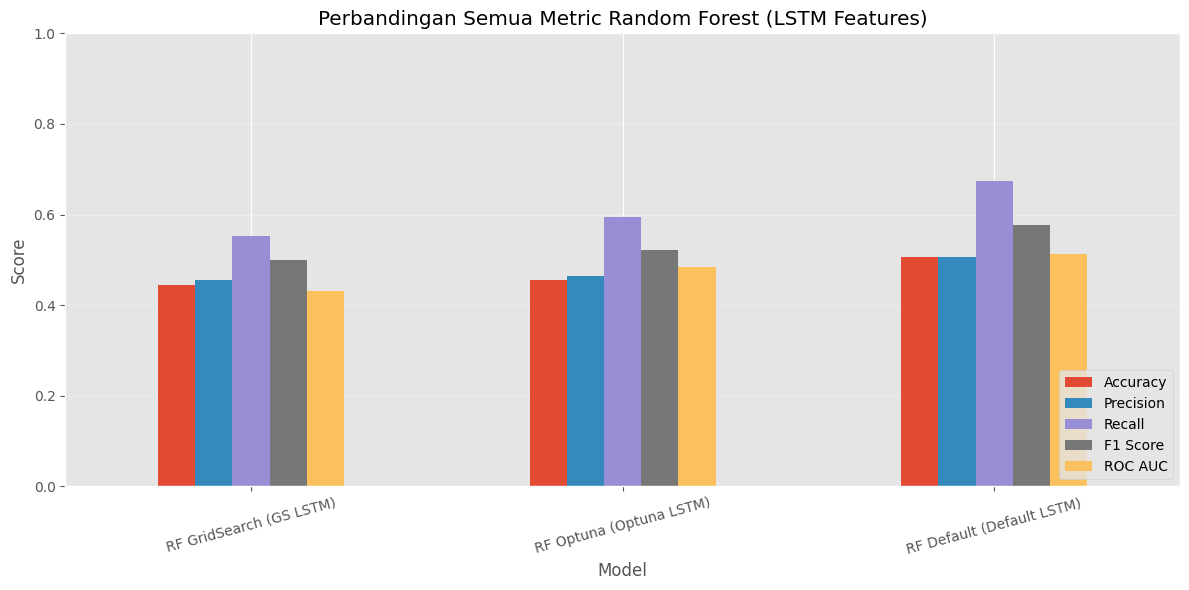

In [50]:
metrics_df = pd.DataFrame({
    'Model': [
        'RF GridSearch (GS LSTM)', 
        'RF Optuna (Optuna LSTM)', 
        'RF Default (Default LSTM)'
    ],
    'Accuracy': [
        acc_rf, 
        acc_optuna, 
        acc_default
    ],
    'Precision': [
        prec_rf, 
        prec_optuna, 
        prec_default
    ],
    'Recall': [
        recall_rf, 
        recall_optuna, 
        recall_default
    ],
    'F1 Score': [
        f1_rf, 
        f1_optuna, 
        f1_default
    ],
    'ROC AUC': [
        rocauc_rf, 
        roauc_optuna, 
        rocauc_default
    ]
})

# Visualisasi perbandingan metrik
metrics_plot = metrics_df.set_index('Model')
metrics_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Perbandingan Semua Metric Random Forest (LSTM Features)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Summary

In [51]:
print("="*70)
print("SUMMARY")
print("="*70)

print("\n📋 DATASET: MIMIC Perform AF")
print(f"   AF Patients: {len(af_files)}")
print(f"   Non-AF Patients: {len(nonaf_files)}")
print(f"   Sampling Rate: {SAMPLING_RATE} Hz")

print("\n📋 DATA SPLIT (sesuai jurnal):")
print(f"   Train: {len(train_af)+len(train_nonaf)} patients (65%)")
print(f"   Test: {len(test_af)+len(test_nonaf)} patients (35%)")

print("\n📋 METHODOLOGY (sesuai jurnal):")
print("   1. Feature Extraction: 5 statistical features")
print("   2. LSTM-based feature extraction (GridSearch, Optuna, Default)")
print("   3. Random Forest classifier (GridSearch, Optuna, Default)")

print("\n📊 RESULTS (RF GridSearch + GS LSTM):")
print(f"   Accuracy : {acc_rf*100:.2f}%")
print(f"   Precision: {prec_rf*100:.2f}%")
print(f"   Recall   : {recall_rf*100:.2f}%")
print(f"   F1 Score : {f1_rf*100:.2f}%")
print(f"   ROC AUC  : {rocauc_rf*100:.2f}%")

print("\n📊 RESULTS (RF Optuna + Optuna LSTM):")
print(f"   Accuracy : {acc_optuna*100:.2f}%")
print(f"   Precision: {prec_optuna*100:.2f}%")
print(f"   Recall   : {recall_optuna*100:.2f}%")
print(f"   F1 Score : {f1_optuna*100:.2f}%")
print(f"   ROC AUC  : {roauc_optuna*100:.2f}%")

print("\n📊 RESULTS (RF Default + Default LSTM):")
print(f"   Accuracy : {acc_default*100:.2f}%")
print(f"   Precision: {prec_default*100:.2f}%")
print(f"   Recall   : {recall_default*100:.2f}%")
print(f"   F1 Score : {f1_default*100:.2f}%")
print(f"   ROC AUC  : {rocauc_default*100:.2f}%")

print("\n" + "="*70)

SUMMARY

📋 DATASET: MIMIC Perform AF
   AF Patients: 16
   Non-AF Patients: 16
   Sampling Rate: 125 Hz

📋 DATA SPLIT (sesuai jurnal):
   Train: 20 patients (65%)
   Test: 12 patients (35%)

📋 METHODOLOGY (sesuai jurnal):
   1. Feature Extraction: 5 statistical features
   2. LSTM-based feature extraction (GridSearch, Optuna, Default)
   3. Random Forest classifier (GridSearch, Optuna, Default)

📊 RESULTS (RF GridSearch + GS LSTM):
   Accuracy : 44.53%
   Precision: 45.48%
   Recall   : 55.33%
   F1 Score : 49.92%
   ROC AUC  : 43.12%

📊 RESULTS (RF Optuna + Optuna LSTM):
   Accuracy : 45.57%
   Precision: 46.51%
   Recall   : 59.44%
   F1 Score : 52.18%
   ROC AUC  : 48.39%

📊 RESULTS (RF Default + Default LSTM):
   Accuracy : 50.71%
   Precision: 50.51%
   Recall   : 67.47%
   F1 Score : 57.77%
   ROC AUC  : 51.31%

